In [73]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob

First lets estabilish criteria for algorithm termination and number of corners that we will search for in the chessboards.

In [74]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

x_corners, y_corners = 11, 7

objp = np.zeros((x_corners*y_corners,3), np.float32)
objp[:,:2] = np.mgrid[0:y_corners,0:x_corners].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space - assuming photo is taken in z plane
imgpoints = [] # 2d points in image plane.

We will use the images provided in the kaggle competition: <href>https://www.kaggle.com/datasets/danielwe14/stereocamera-chessboard-pictures?resource=download</href>

In [75]:
images = glob.glob('chess_callibration/*.png')
#print(images)
len(images)

20

For each of the photos we look for the corners and save them.

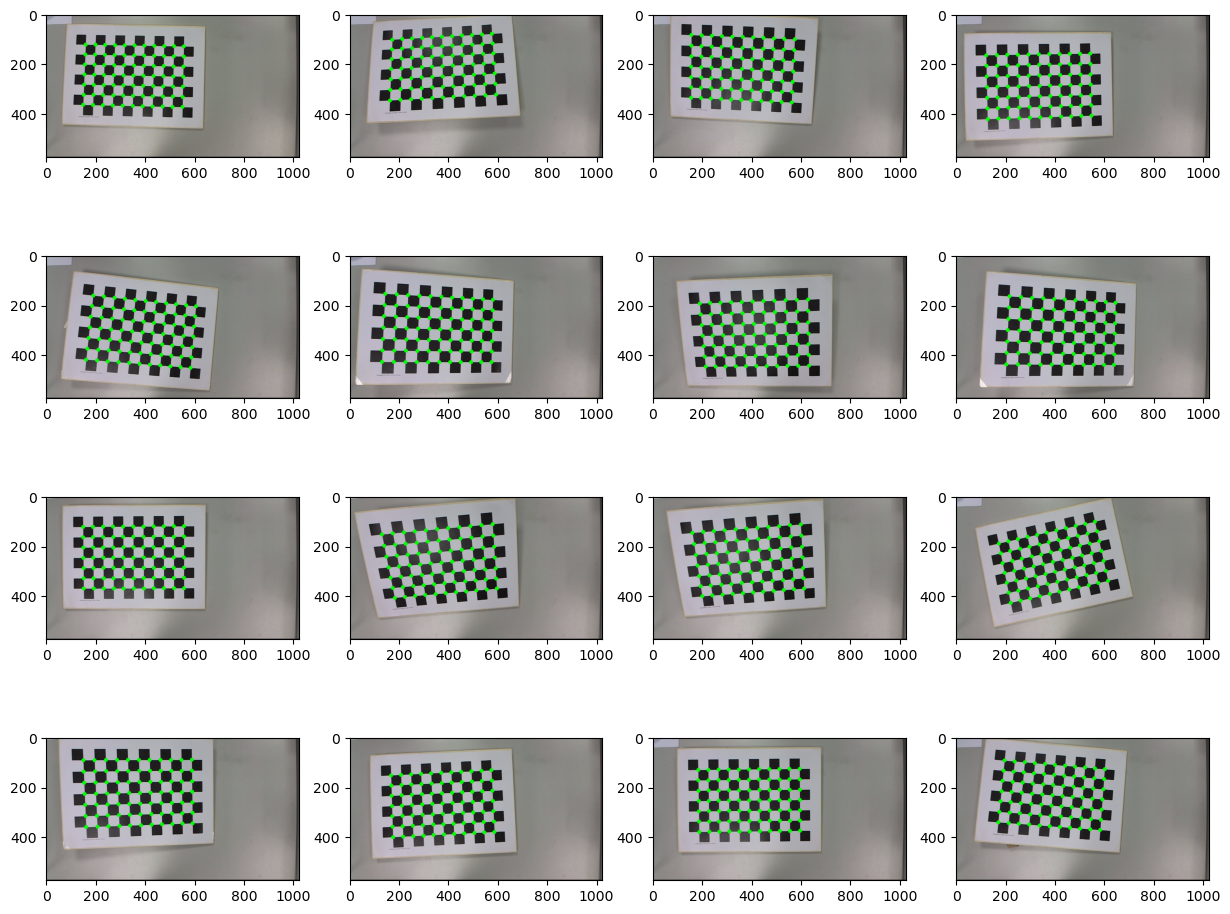

In [76]:
fig, ax = plt.subplots(4,4,figsize=(15,12))

for i, fname in enumerate(images[:-4]):

      row = i//4
      col = i%4

      img = cv.imread(fname)
      gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


      #ret, corners = cv.findChessboardCorners(gray, (y_corners,x_corners), flags=CALIB_CB_ADAPTIVE_THRESH)
      ret, corners = cv.findChessboardCorners(gray, (y_corners,x_corners))

      if ret == True:
            objpoints.append(objp)
            #increase accuracy of found points
            corners2 = cv.cornerSubPix(gray,corners, (30,30), (-1,-1), criteria)
            imgpoints.append(corners)

      # Draw and display the corners
      #cv.drawChessboardCorners(img, (y_corners,x_corners), corners2, ret)
            for corner in corners2:
                  x, y = corner.ravel().astype(int)
                  cv.circle(img, (x, y), 8, (0, 255, 0), -1)

            rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            ax[row,col].imshow(rgb)

plt.show()

Nice, now we will use build-in cv function to retrieve camera matrix using found points.

In [77]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Lets try to undistort some of the pictures using results.

C:\Users\opala\AppData\Local\Temp\ipykernel_13036\2688133975.py:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners2 = np.int0(corners2)


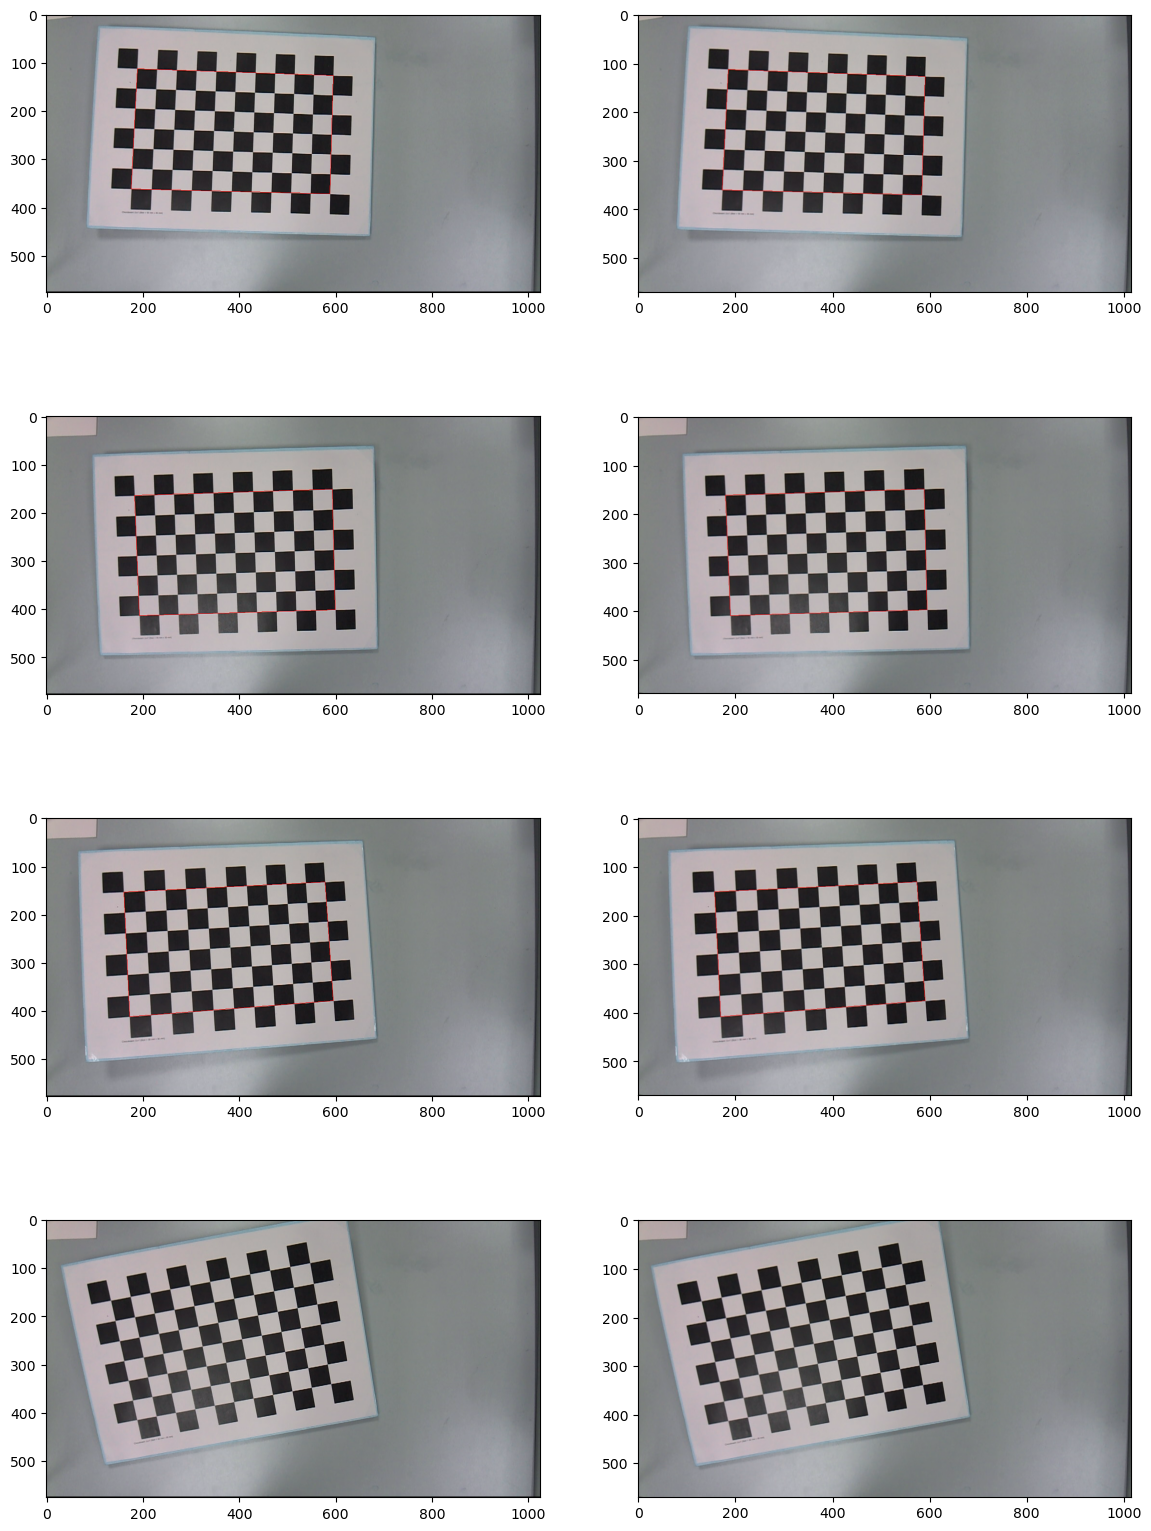

In [80]:
fig, ax = plt.subplots(4,2,figsize=(14,20))

for i, fname in enumerate(images[-4:]):

    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (y_corners,x_corners), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        corners2 = np.int0(corners2)
        sorted_corners = sorted(corners2, key=lambda x: (x[0][0], x[0][1]))

        # Draw lines between outermost corners
        if i < 3:
            cv.line(img, tuple(sorted_corners[0][0]), tuple(sorted_corners[-7][0]), (255, 0, 0), 1)
            cv.line(img, tuple(sorted_corners[0][0]), tuple(sorted_corners[6][0]), (255, 0, 0), 1)
            cv.line(img, tuple(sorted_corners[-1][0]), tuple(sorted_corners[-7][0]), (255, 0, 0), 1)
            cv.line(img, tuple(sorted_corners[6][0]), tuple(sorted_corners[-1][0]), (255, 0, 0), 1)
            #cv.drawChessboardCorners(img, (y_corners,x_corners), corners2, ret)

    h, w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    ax[i,0].imshow(img)
    ax[i,1].imshow(dst)

plt.show()

Lets check the error or re-projection. It tells us how close to finding good parameters we've come.

In [81]:
mean_error = 0
for i in range(len(objpoints)):
 imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
 error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
 mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.020095799174603402


We can see that the error is quite small, meaning that reconstruction of the camera matrix was successful.

Lets try to find a pose estimation for some of the board pictures. First well define a simple function for drawing the axis.

In [97]:
def draw(img, corners, imgpts):
 corner = tuple(np.int0(corners[0]).ravel())
 img = cv.line(img, corner, tuple(np.int0(imgpts[0]).ravel()), (255,0,0), 5)
 img = cv.line(img, corner, tuple(np.int0(imgpts[1]).ravel()), (0,255,0), 5)
 img = cv.line(img, corner, tuple(np.int0(imgpts[2]).ravel()), (0,0,255), 5)
 return img

Now we once again define termination criteria for the searching algorithm.

In [98]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((11*7,3), np.float32)
objp[:,:2] = np.mgrid[0:11,0:7].T.reshape(-1,2)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

Finally for each image we search for the grid, calculate rotation and translation and use them to project on a 3D space.

C:\Users\opala\AppData\Local\Temp\ipykernel_13036\964704701.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corner = tuple(np.int0(corners[0]).ravel())
C:\Users\opala\AppData\Local\Temp\ipykernel_13036\964704701.py:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  img = cv.line(img, corner, tuple(np.int0(imgpts[0]).ravel()), (255,0,0), 5)
C:\Users\opala\AppData\Local\Temp\ipykernel_13036\964704701.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  img = cv.line(img, corner, tuple(np.int0(imgpts[1]).ravel()), (0,255,0), 5)
C:\Users\opala\AppData\Local\Temp\ipykernel_13036\964704701.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  img = cv.line(img, corner, tuple(np.int0(imgpts[2]).ravel()), (0,0,255), 5)


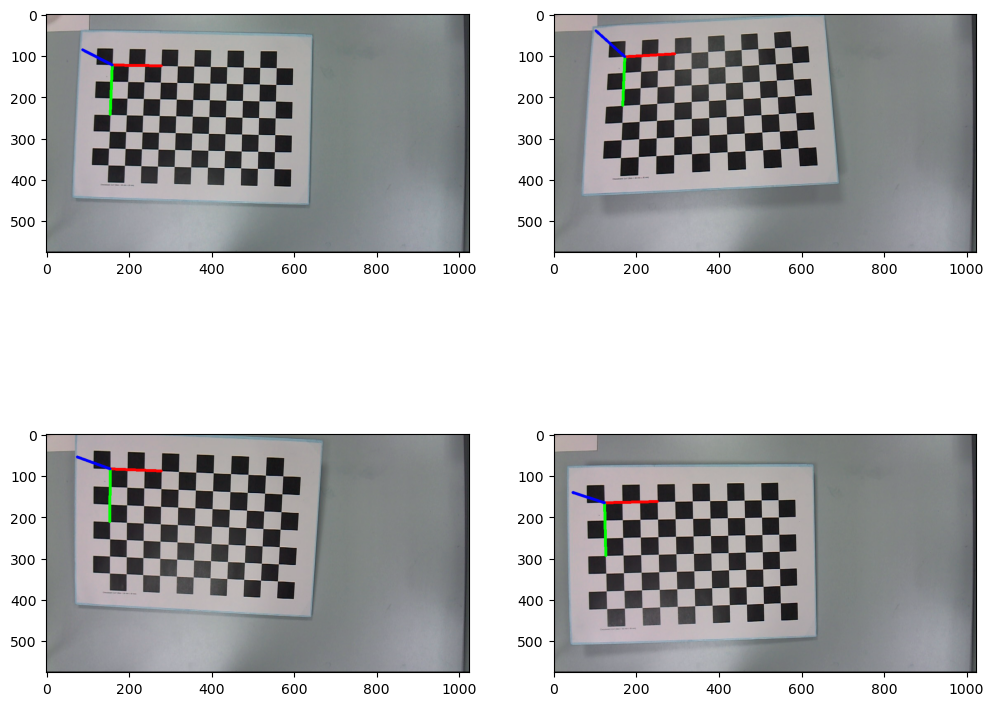

In [99]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

for i, fname in enumerate(images[:4]):
 img = cv.imread(fname)
 gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 ret, corners = cv.findChessboardCorners(gray, (11,7),None)
 if ret == True:
    corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    # Find the rotation and translation vectors.
    ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
    # project 3D points to image plane
    imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
    img = draw(img,corners2,imgpts)
    ax[i//2,i%2].imshow(img)
    #k = cv.waitKey(0) & 0xFF
    #if k == ord('s'):
    #    cv.imwrite(fname[:6]+'.png', img)
plt.show()